<a href="https://colab.research.google.com/github/janaahmeed/ML-project-/blob/main/ML_Image_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc,
    adjusted_rand_score
)
from sklearn.cluster import KMeans
from sklearn.metrics import ConfusionMatrixDisplay

#Checking the Path

In [ ]:
import kagglehub

data_root = kagglehub.dataset_download("moltean/fruits")
print("Downloaded to:", data_root)

# List everything inside it
print("Contents:", os.listdir(data_root))


Using Colab cache for faster access to the 'fruits' dataset.
Downloaded to: /kaggle/input/fruits
Contents: ['fruits-360_100x100', 'fruits-360_3-body-problem', 'fruits-360_dataset_meta', 'fruits-360_original-size', 'fruits-360_multi']


In [ ]:
print(os.listdir("/kaggle/input/fruits/fruits-360_100x100"))


['fruits-360']


In [ ]:
base = "/kaggle/input/fruits/fruits-360_100x100/fruits-360"
for item in os.listdir(base):
    path = os.path.join(base, item)
    print(item, " --> DIR?" , os.path.isdir(path))
    if os.path.isdir(path):
        print("Contents:", os.listdir(path)[:10])


LICENSE  --> DIR? False
Training  --> DIR? True
Contents: ['Melon Piel de Sapo 1', 'Dates 1', 'Avocado Black 2', 'Nectarine Flat 2', 'Apple Crimson Snow 1', 'Onion Red 1', 'Cherry Wax Yellow 1', 'Pear 10', 'Cherry 3', 'Avocado Green 1']
README.md  --> DIR? False
Test  --> DIR? True
Contents: ['Melon Piel de Sapo 1', 'Dates 1', 'Avocado Black 2', 'Nectarine Flat 2', 'Apple Crimson Snow 1', 'Onion Red 1', 'Cherry Wax Yellow 1', 'Pear 10', 'Cherry 3', 'Avocado Green 1']


# Dataset paths

In [ ]:
base_dir = "/kaggle/input/fruits/fruits-360_100x100/fruits-360"
train_dir = os.path.join(base_dir, "Training")
test_dir  = os.path.join(base_dir, "Test")

# Selected Classes

In [ ]:

selected_classes = [
    "Apple Red 1",
    "Banana 1",
    "Orange 1",
    "Pineapple 1",
    "Strawberry 1"
]

# Feature Extraction

In [ ]:
def extract_features(image):
    gray = np.mean(image, axis=2)

    hog_features = hog(
        gray,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        feature_vector=True
    )

    color_hist = []
    for i in range(3):
        hist, _ = np.histogram(
            image[:, :, i],
            bins=32,
            range=(0, 1),
            density=True
        )
        color_hist.extend(hist)

    return np.hstack([hog_features, color_hist])

# Load Dataset

In [ ]:
def load_data(folder):
    X, y = [], []

    for cls in selected_classes:
        cls_path = os.path.join(folder, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)

            img = Image.open(img_path).convert("RGB")
            img = np.array(img, dtype=np.float32) / 255.0

            X.append(extract_features(img))
            y.append(cls)

    return np.array(X), np.array(y)

X_train_raw, y_train_raw = load_data(train_dir)
X_test_raw,  y_test_raw  = load_data(test_dir)

print("Train samples:", X_train_raw.shape)
print("Test samples:", X_test_raw.shape)


Train samples: (2443, 896)
Test samples: (820, 896)


# Encode labels

In [ ]:
le = LabelEncoder()
y_all = np.hstack([y_train_raw, y_test_raw])
y_all_enc = le.fit_transform(y_all)
X_all = np.vstack([X_train_raw, X_test_raw])

# Train / Test split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all_enc,
    test_size=0.25,
    random_state=42,
   stratify=y_all_enc
)

# Dataset Summary & Visualization

In [ ]:
print("===== Dataset Information =====")
print("Dataset: Fruits-360")
print("Selected Classes:", selected_classes)
print("Number of Classes:", len(selected_classes))
print("Total samples:", X_all.shape[0])
print("Image size: 100x100 RGB")
print("Training samples:", X_train.shape[0])
print("Testing samples :", X_test.shape[0])


===== Dataset Information =====
Dataset: Fruits-360
Selected Classes: ['Apple Red 1', 'Banana 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1']
Number of Classes: 5
Total samples: 3263
Image size: 100x100 RGB
Training samples: 2447
Testing samples : 816



Training Images per Class:
Apple Red 1     : 492
Banana 1        : 490
Orange 1        : 479
Pineapple 1     : 490
Strawberry 1    : 492


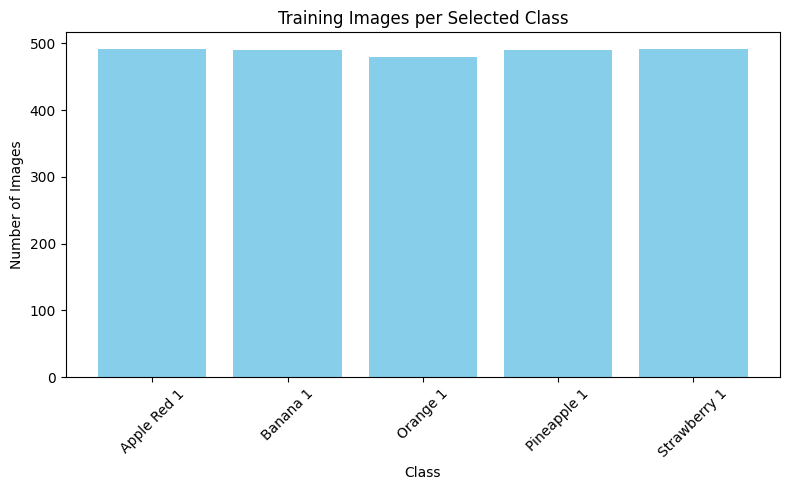

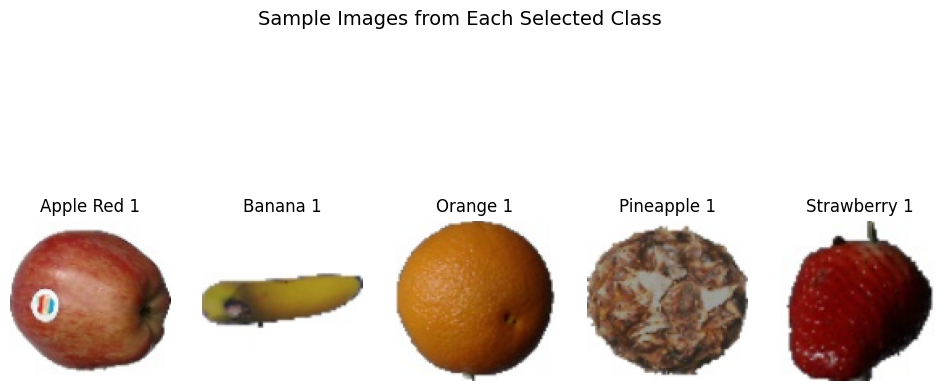


Dataset is ready for Step 2: Model Building


In [ ]:
# Count images per class
train_counts = {
    cls: len(os.listdir(os.path.join(train_dir, cls))) if os.path.isdir(os.path.join(train_dir, cls)) else 0
    for cls in selected_classes
}

print("\nTraining Images per Class:")
for cls, count in train_counts.items():
    print(f"{cls:15s} : {count}")

# Visualization: Number of Images per Class
plt.figure(figsize=(8,5))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title("Training Images per Selected Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sample Images
plt.figure(figsize=(12,6))
for i, cls in enumerate(selected_classes):
    cls_folder = os.path.join(train_dir, cls)
    sample_img_name = next((f for f in os.listdir(cls_folder) if f.lower().endswith(('.jpg','.png'))), None)
    if sample_img_name:
        sample_img_path = os.path.join(cls_folder, sample_img_name)
        img = cv2.imread(sample_img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,5,i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
plt.suptitle("Sample Images from Each Selected Class", fontsize=14)
plt.show()

print("\nDataset is ready for Step 2: Model Building")


# Scaling + PCA

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

pca = PCA(n_components=0.95, random_state=42)  # keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("PCA components:", X_train_pca.shape[1])

PCA components: 165


# Feature Extraction Info

In [ ]:
sample_img_path = os.path.join(
    train_dir,
    selected_classes[0],
    os.listdir(os.path.join(train_dir, selected_classes[0]))[0]
)

sample_img = np.array(Image.open(sample_img_path).convert("RGB"), dtype=np.float32) / 255.0
sample_features = extract_features(sample_img)

print("\nNumber of features extracted per image:", len(sample_features))
print("Feature types: HOG + color histogram (RGB channels)")
print("Feature dimension after PCA:", X_train_pca.shape[1])



Number of features extracted per image: 896
Feature types: HOG + color histogram (RGB channels)
Feature dimension after PCA: 165


#LOGISTIC REGRESSION

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Accuracy: 1.0


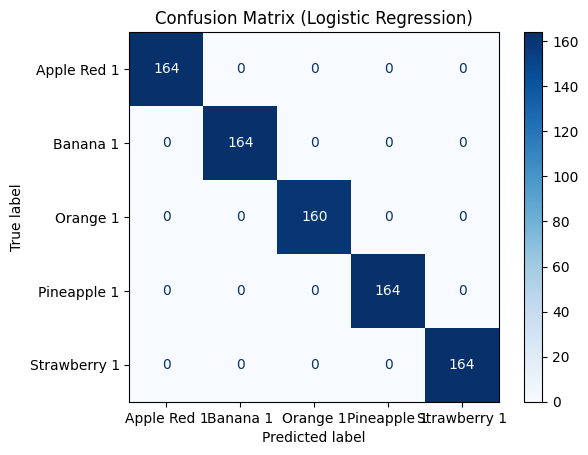

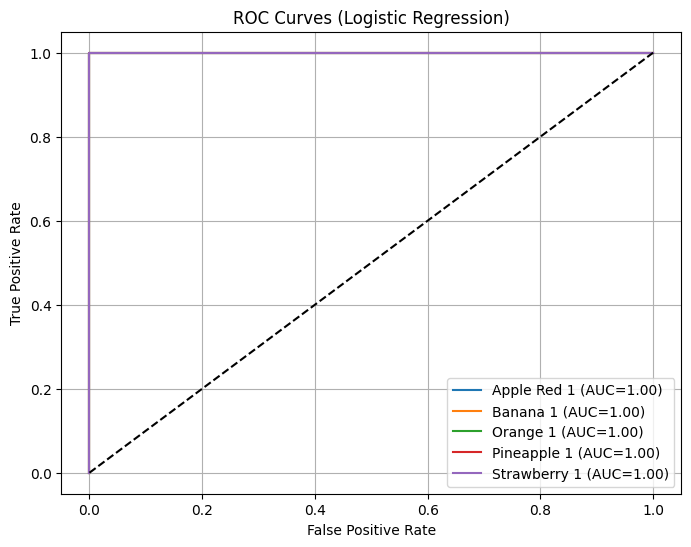

In [ ]:
lr = LogisticRegression(
    C=1,
    solver="saga",
    penalty="l2",
    max_iter=400,
    multi_class="multinomial",
    n_jobs=-1,
    random_state=42
)

lr.fit(X_train_pca, y_train)
y_pred = lr.predict(X_test_pca)

acc_lr = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", acc_lr)

# Confusion Matrix (LR)
cm_lr = confusion_matrix(y_test, y_pred)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=selected_classes)
disp_lr.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

# ROC Curves (LR)
y_test_bin = label_binarize(y_test, classes=np.arange(5))
y_proba = lr.predict_proba(X_test_pca)

plt.figure(figsize=(8, 6))
for i, cls in enumerate(selected_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.legend()
plt.title("ROC Curves (Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

#KMEANS

In [ ]:
kmeans = KMeans(
    n_clusters=5,
    n_init=50,        # more initializations
    max_iter=500,     # more iterations
    tol=1e-6,         # tighter convergence
    algorithm='elkan', # faster and more precise for high-dim
    random_state=42
)

kmeans.fit(X_train_pca)
cluster_labels = kmeans.predict(X_test_pca)

#  clustering metric
ari = adjusted_rand_score(y_test, cluster_labels)
print("KMeans ARI:", ari)

# Map clusters → majority labels
cluster_to_label = {}
for c in range(5):
    mask = cluster_labels == c
    if mask.sum() == 0:
        continue
    values, counts = np.unique(y_test[mask], return_counts=True)
    cluster_to_label[c] = values[np.argmax(counts)]

mapped_preds = np.array([cluster_to_label[c] for c in cluster_labels])
acc_kmeans = accuracy_score(y_test, mapped_preds)
print("Mapped KMeans Accuracy:", acc_kmeans)

# Confusion Matrix (KMeans)
cm_k = confusion_matrix(y_test, mapped_preds)
disp_k = ConfusionMatrixDisplay(confusion_matrix=cm_k, display_labels=selected_classes)
disp_k.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (KMeans)")
plt.show()
